# Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
os.chdir("/home2/jgcw74/l3_project")  # go to project root
import importlib

import helpers
import dataset_processing
import models
import xai

torch_device = helpers.utils.get_torch_device()

/home2/jgcw74/l3_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
import typing as t
from pathlib import Path
import json

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
AVAILABLE_MODELS = ("ConvNeXtSmall", "ResNet50", "SwinTransformerSmall")

# Helper functions

In [6]:
def get_dataset_and_model(dataset_n: dataset_processing.DATASET_NAMES, model_n: models.MODEL_NAMES):
    model_type = models.get_model_type(model_n)
    ds = dataset_processing.get_dataset_object(dataset_n, "test", model_type.expected_input_dim, 32, 4, torch_device)

    m = model_type(False, ds.N_BANDS, ds.N_CLASSES).to(torch_device)
    weights_path = json.load(Path("weights_paths.json").open("r"))[dataset_n][model_n]
    m.load_weights(Path("checkpoints") / dataset_n / model_n / weights_path)

    return ds, m

# Figure 1 - KPCACAM for ResNet50 on EuroSATMS

In [7]:
dataset_name = "EuroSATMS"
dataset, model = get_dataset_and_model(dataset_name, "ResNet50")
print(list(enumerate(dataset.classes)))

[(0, 'AnnualCrop'), (1, 'Forest'), (2, 'HerbaceousVegetation'), (3, 'Highway'), (4, 'Industrial'), (5, 'Pasture'), (6, 'PermanentCrop'), (7, 'Residential'), (8, 'River'), (9, 'SeaLake')]


In [8]:
class_idx = 8  # "River"
batch_num = 0
kpca_exp = xai.get_explainer_object(
    "KPCACAM", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
kpca_exp.force_load()

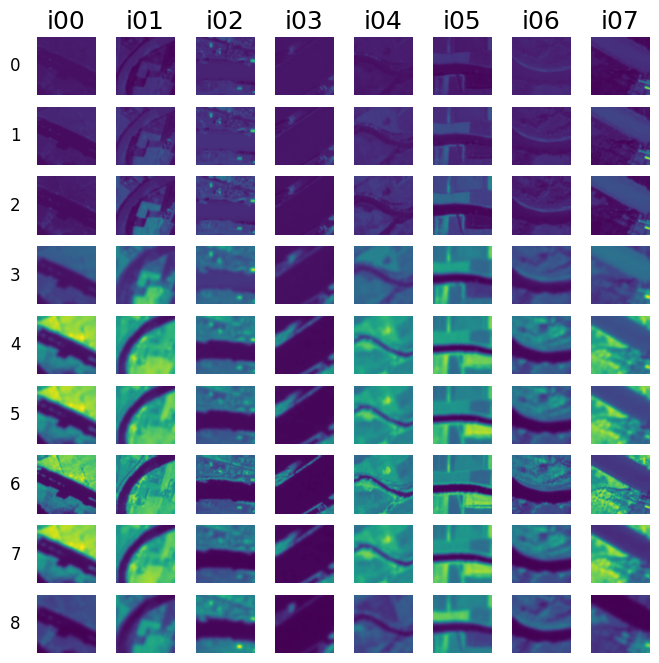

In [9]:
importlib.reload(helpers.plotting)
helpers.plotting.show_image(kpca_exp.input[:8])

PartitionSHAP


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12969846..6.7247224].


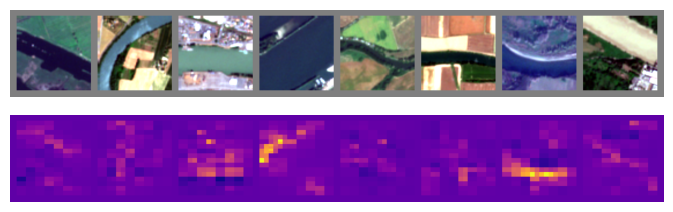

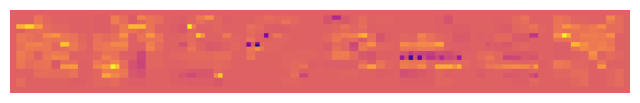

GradCAM


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12969846..6.7247224].


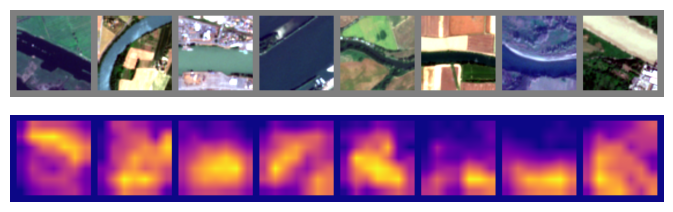

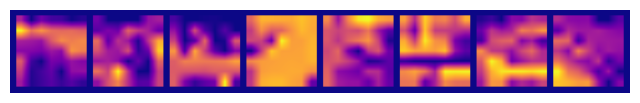

KPCACAM


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12969846..6.7247224].


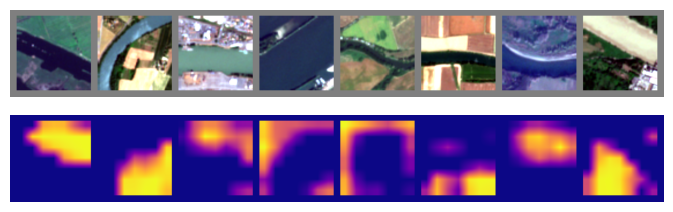

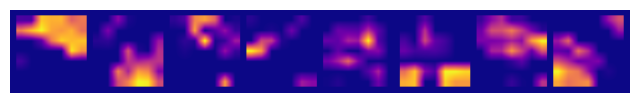

In [10]:
for e_name in t.get_args(xai.EXPLAINER_NAMES):
    print(e_name)

    grad_exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
    )
    grad_exp.force_load()
    helpers.plotting.visualise_importance(grad_exp.input[:8, [2,1,0]],
                                          grad_exp.explanation[:8], alpha=0.5, final_fig_size=(10, 2.5),
                                          with_colorbar=False, band_idxs=dataset.rgb_indices, show_samples_separate=True)
    plt.show()

    randomised_exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / "combined" / "randomised",
    )
    randomised_exp.force_load()
    helpers.plotting.visualise_importance(randomised_exp.input[:8].numpy(force=True),
                                          randomised_exp.explanation[:8],
                                          alpha=1., with_colorbar=False, band_idxs=dataset.rgb_indices)
    plt.show()

KPCACAM shows extremely similar explanations for the randomised model to those provided for the un-randomised model.

# Figure 2 - GradCAM is worse than random at identifying relevant pixels for PatternNet.River

In [17]:
dataset_name = "PatternNet"
dataset, model = get_dataset_and_model(dataset_name, "ConvNeXtSmall")
print(list(enumerate(dataset.classes)))

[(0, 'airplane'), (1, 'baseball_field'), (2, 'basketball_court'), (3, 'beach'), (4, 'bridge'), (5, 'cemetery'), (6, 'chaparral'), (7, 'christmas_tree_farm'), (8, 'closed_road'), (9, 'coastal_mansion'), (10, 'crosswalk'), (11, 'dense_residential'), (12, 'ferry_terminal'), (13, 'football_field'), (14, 'forest'), (15, 'freeway'), (16, 'golf_course'), (17, 'harbor'), (18, 'intersection'), (19, 'mobile_home_park'), (20, 'nursing_home'), (21, 'oil_gas_field'), (22, 'oil_well'), (23, 'overpass'), (24, 'parking_lot'), (25, 'parking_space'), (26, 'railway'), (27, 'river'), (28, 'runway'), (29, 'runway_marking'), (30, 'shipping_yard'), (31, 'solar_panel'), (32, 'sparse_residential'), (33, 'storage_tank'), (34, 'swimming_pool'), (35, 'tennis_court'), (36, 'transformer_station'), (37, 'wastewater_treatment_plant')]


In [28]:
class_idx = 27  # "River"
batch_num = 1
shap_exp = xai.get_explainer_object(
    "PartitionSHAP", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
shap_exp.force_load()

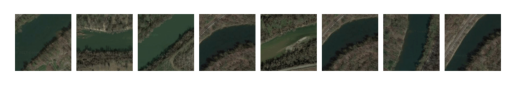

In [29]:
helpers.plotting.show_image(shap_exp.input[:8], padding=20, padding_value=1)

GradCAM


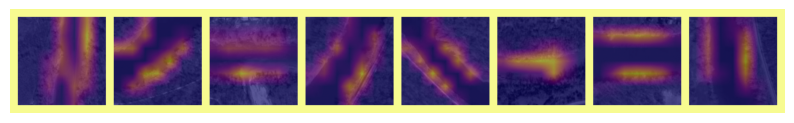

KPCACAM


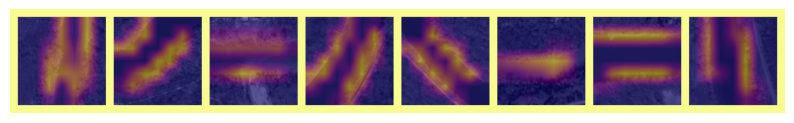

In [20]:
for e_name in ("GradCAM", "KPCACAM"):
    print(e_name)

    grad_exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
    )
    grad_exp.force_load()
    helpers.plotting.visualise_importance(grad_exp.input[:8], grad_exp.explanation[:8],
                                          alpha=0.5, final_fig_size=(10, 2.2), padding_value=1,
                                          with_colorbar=False, band_idxs=dataset.rgb_indices, show_samples_separate=False)
    plt.show()

In [26]:
from evaluate_xai import correctness
importlib.reload(correctness)

<module 'evaluate_xai.correctness' from '/home2/jgcw74/l3_project/evaluate_xai/correctness.py'>

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920928955078125e-07..0.9374364912509918].


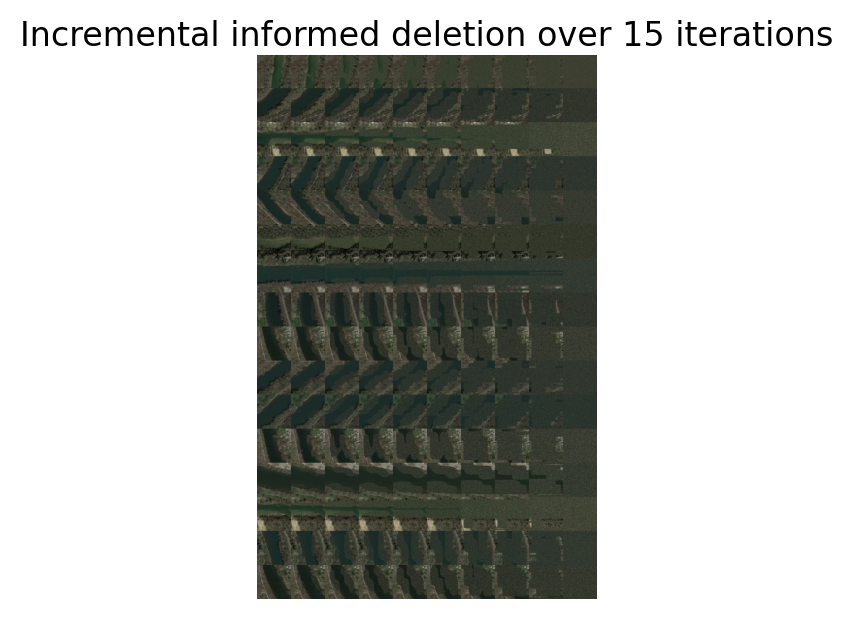

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

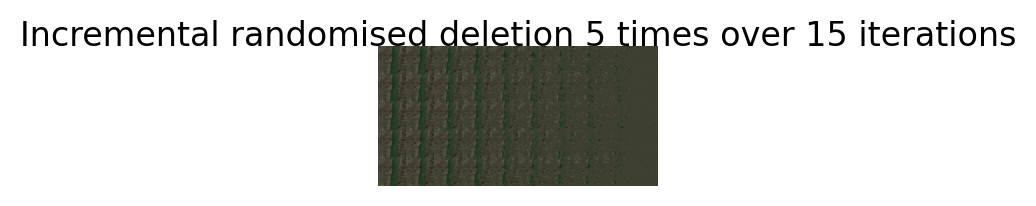

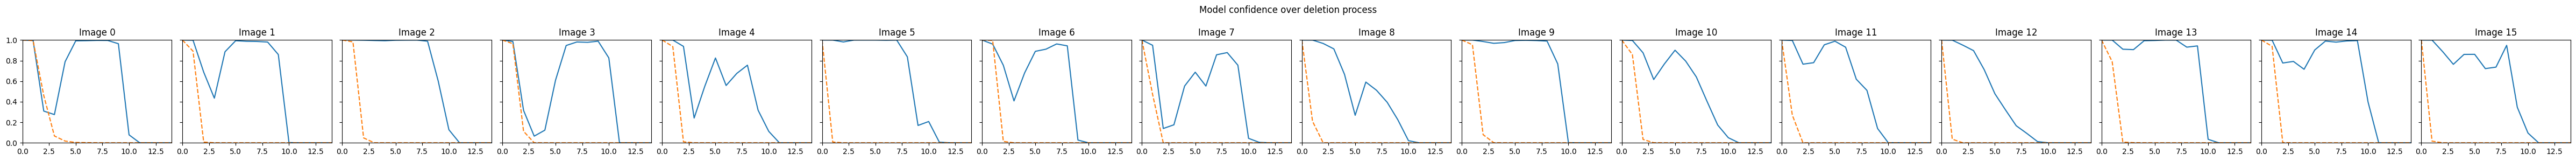

{'informed': array([7.889232 , 8.315438 , 9.199526 , 7.320862 , 6.4724507, 8.697521 ,
        7.036832 , 6.093528 , 6.0566053, 9.175697 , 6.718219 , 7.183568 ,
        5.1246767, 9.213384 , 9.038432 , 7.71894  ], dtype=float32),
 'random': array([2.0446095 , 1.3995178 , 1.5299953 , 1.5775874 , 1.447079  ,
        0.5079646 , 1.5111916 , 0.9709652 , 0.70942163, 1.5350572 ,
        1.3930287 , 0.7699384 , 0.536021  , 1.2982152 , 1.4411395 ,
        0.5168414 ], dtype=float32)}

In [27]:
cor_metric = correctness.Correctness(grad_exp, max_batch_size=8)
cor_metric.evaluate("incremental_deletion", deletion_method="shuffle", visualise=True)

NB: it does kind of look more like an in-distribution river image again once there have been enough deletions (on both sides of the river bank). A sign that this metric maybe isn't the most suited to satellite imagery where large areas are important. In this case, it *has* successfully identified pixels; it's just that 'deleting' them has inadvertently led to a river-like image again.

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

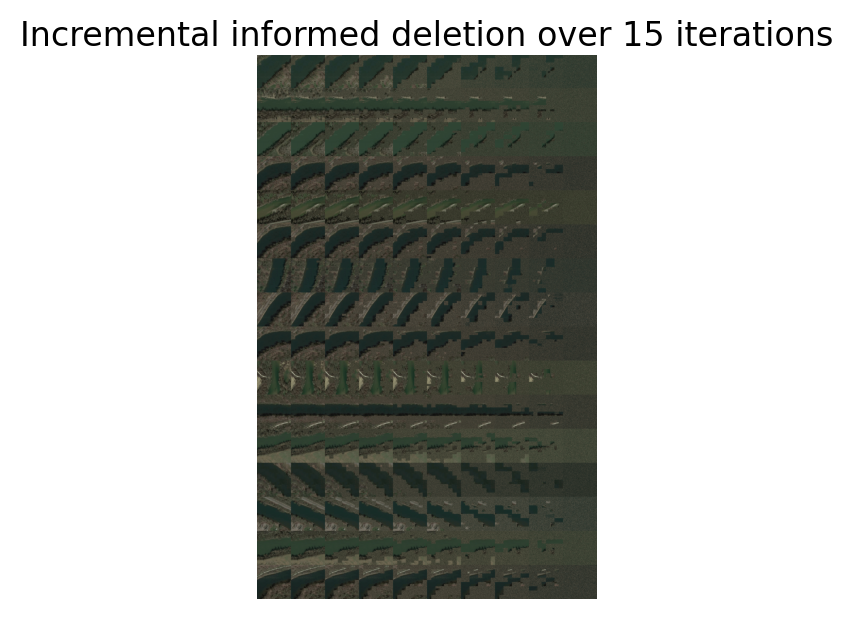

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

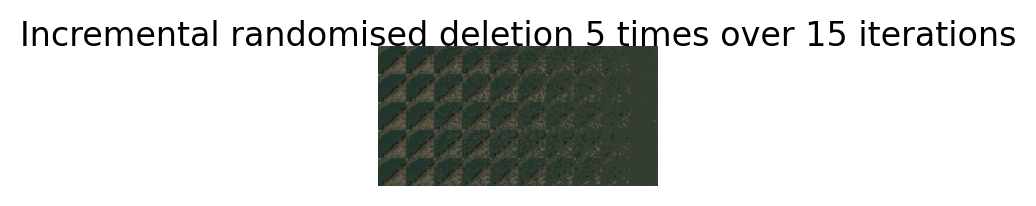

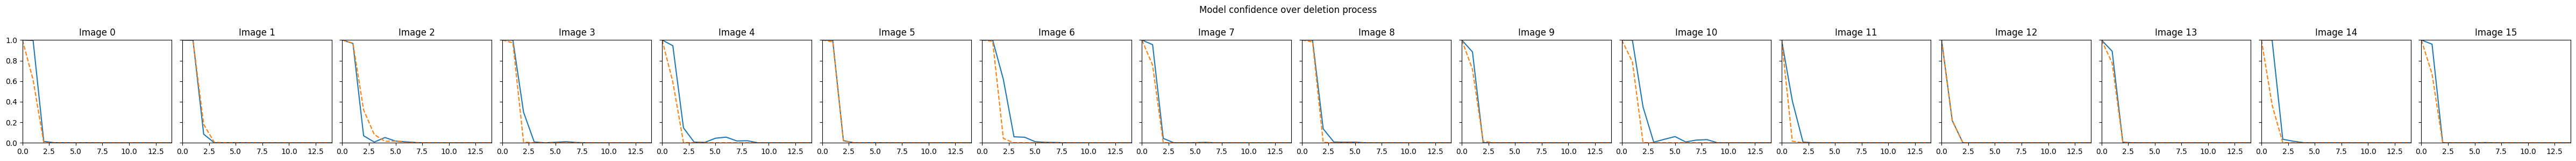

{'informed': array([1.5145712 , 1.5872896 , 1.6240871 , 1.8280078 , 1.7417349 ,
        1.5229961 , 2.2501907 , 1.505537  , 1.6585968 , 1.3872111 ,
        2.0174916 , 0.91820884, 0.71815497, 1.3975527 , 1.5515685 ,
        1.4651245 ], dtype=float32),
 'random': array([1.1135542 , 1.6833172 , 1.9064397 , 1.4811659 , 1.0959146 ,
        1.501445  , 1.5304075 , 1.2562159 , 1.4865546 , 1.23411   ,
        1.290525  , 0.51651406, 0.7164993 , 1.2772037 , 0.8699204 ,
        1.1715893 ], dtype=float32)}

In [30]:
cor_metric2 = correctness.Correctness(shap_exp, max_batch_size=8)
cor_metric2.evaluate("incremental_deletion", deletion_method="shuffle", visualise=True)

While the above is true, PartitionSHAP still manages to better on the same class of images so clearly it has identified the important locations better? PartitionSHAP is roughly on par with random.